# Chapter 14. Recurrent Neural Network

출처 : Hands on Machine Learning ( 그림과 일부 자료들은 책 캡쳐 자료라 발표 후 삭제하겠습니다 ~ )

### 순환 신경망: 미래를 어느 정도 예측할 수 있는 네트워크
- 고정 길이 입력이 아니라 임의 길이를 가진 시퀀스를 다룰 수 있음. ( 문장, 문서, 오디오 샘플 )
- 자동 번역, STT, NLP 에 유용
- 멜로디 작성, 문장 생성, 이미지 캡션

## 14.1 순환 뉴런
순환 신경망은 각 타임 스텝 t 마다 이 순환 뉴런 x(t) 과 이전 타임 스텝의 출력인  y(t-1) 을 입력으로 받습니다.

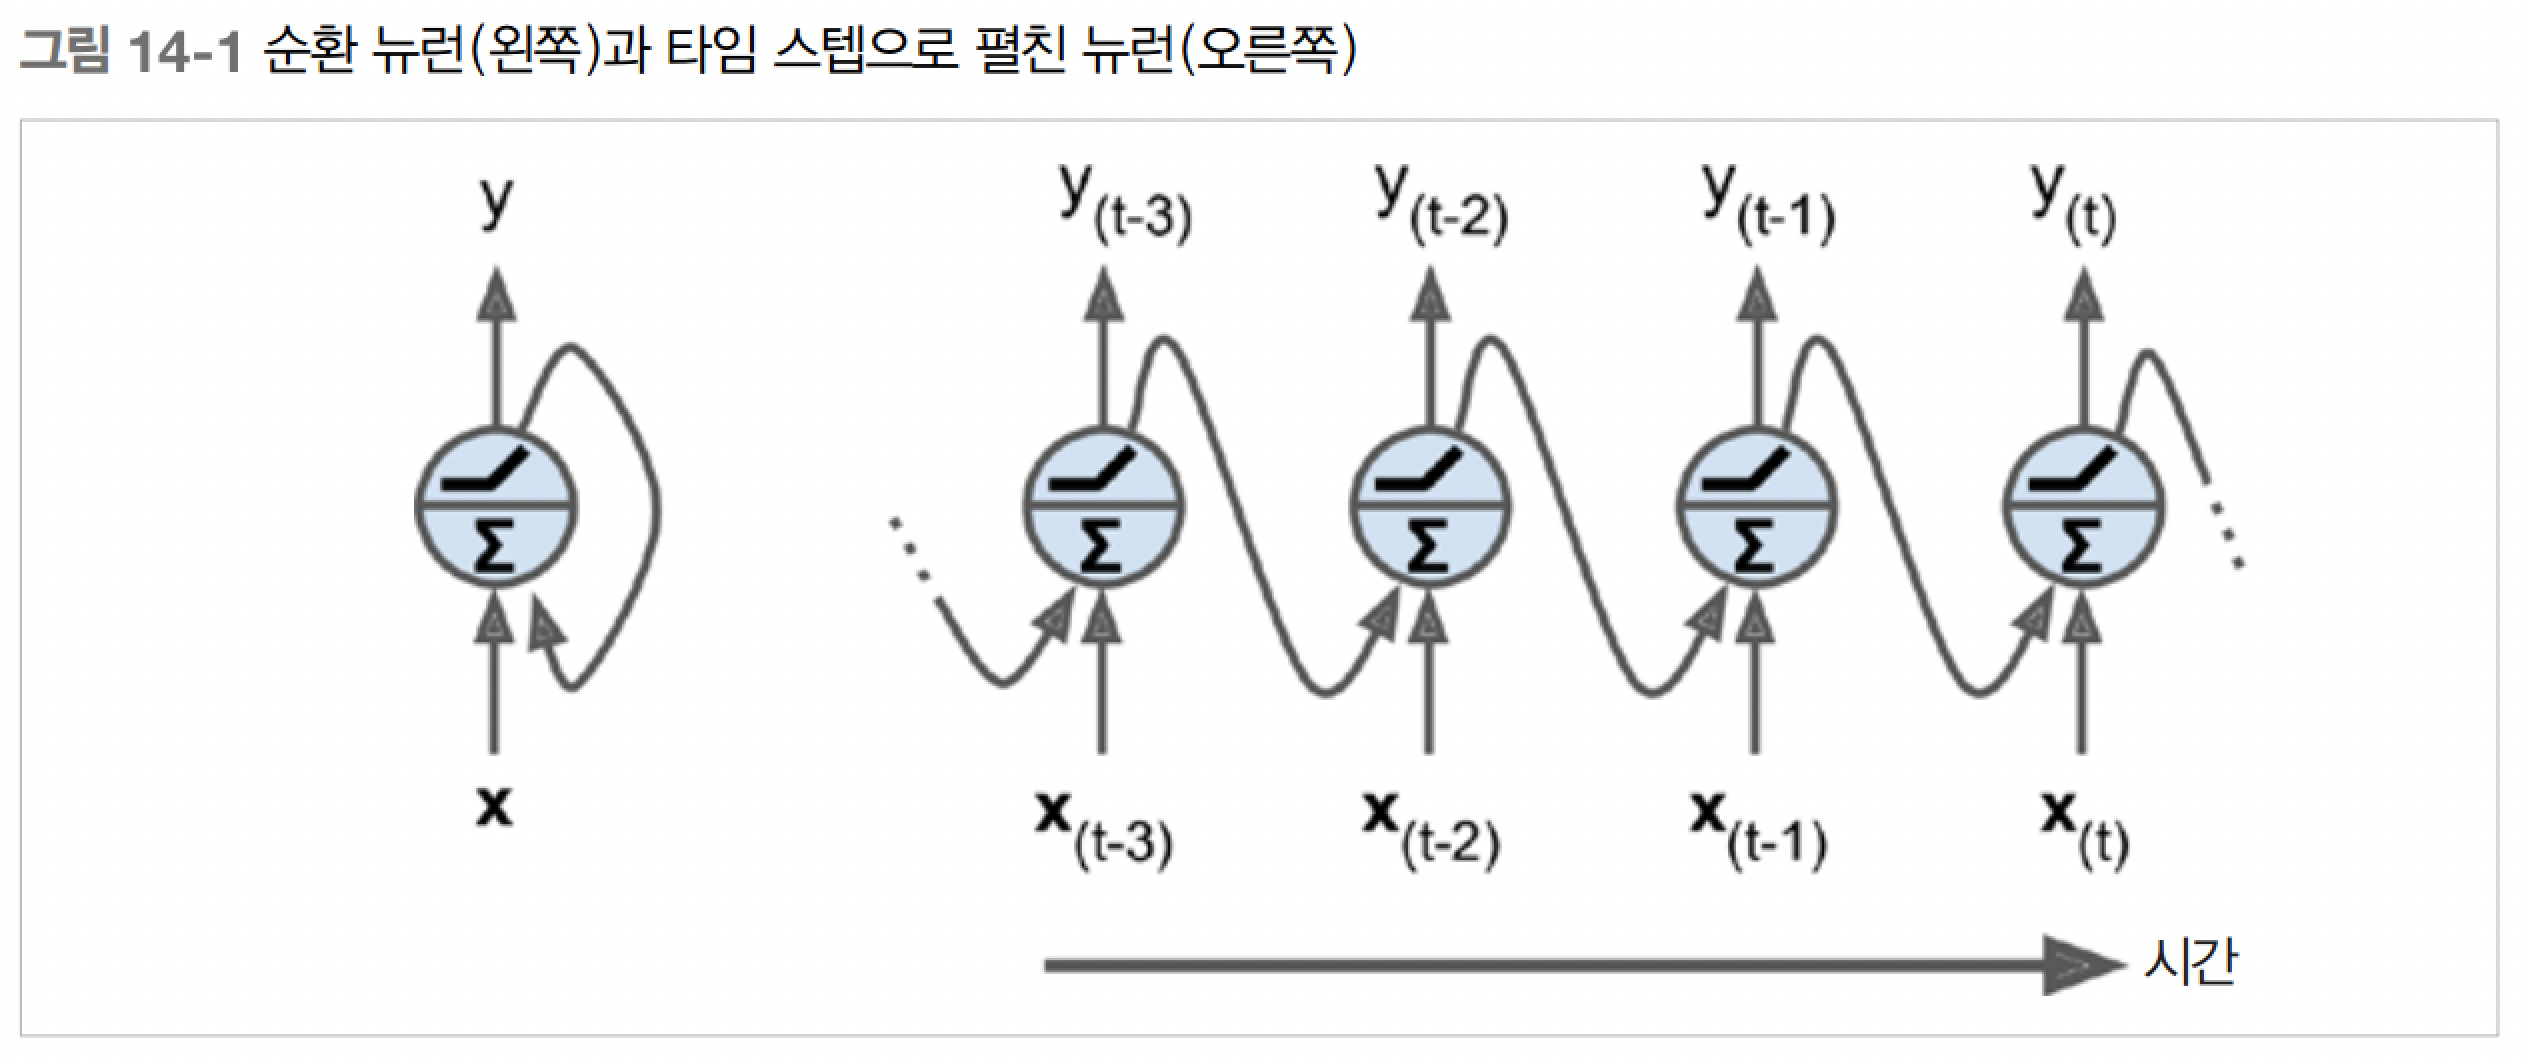

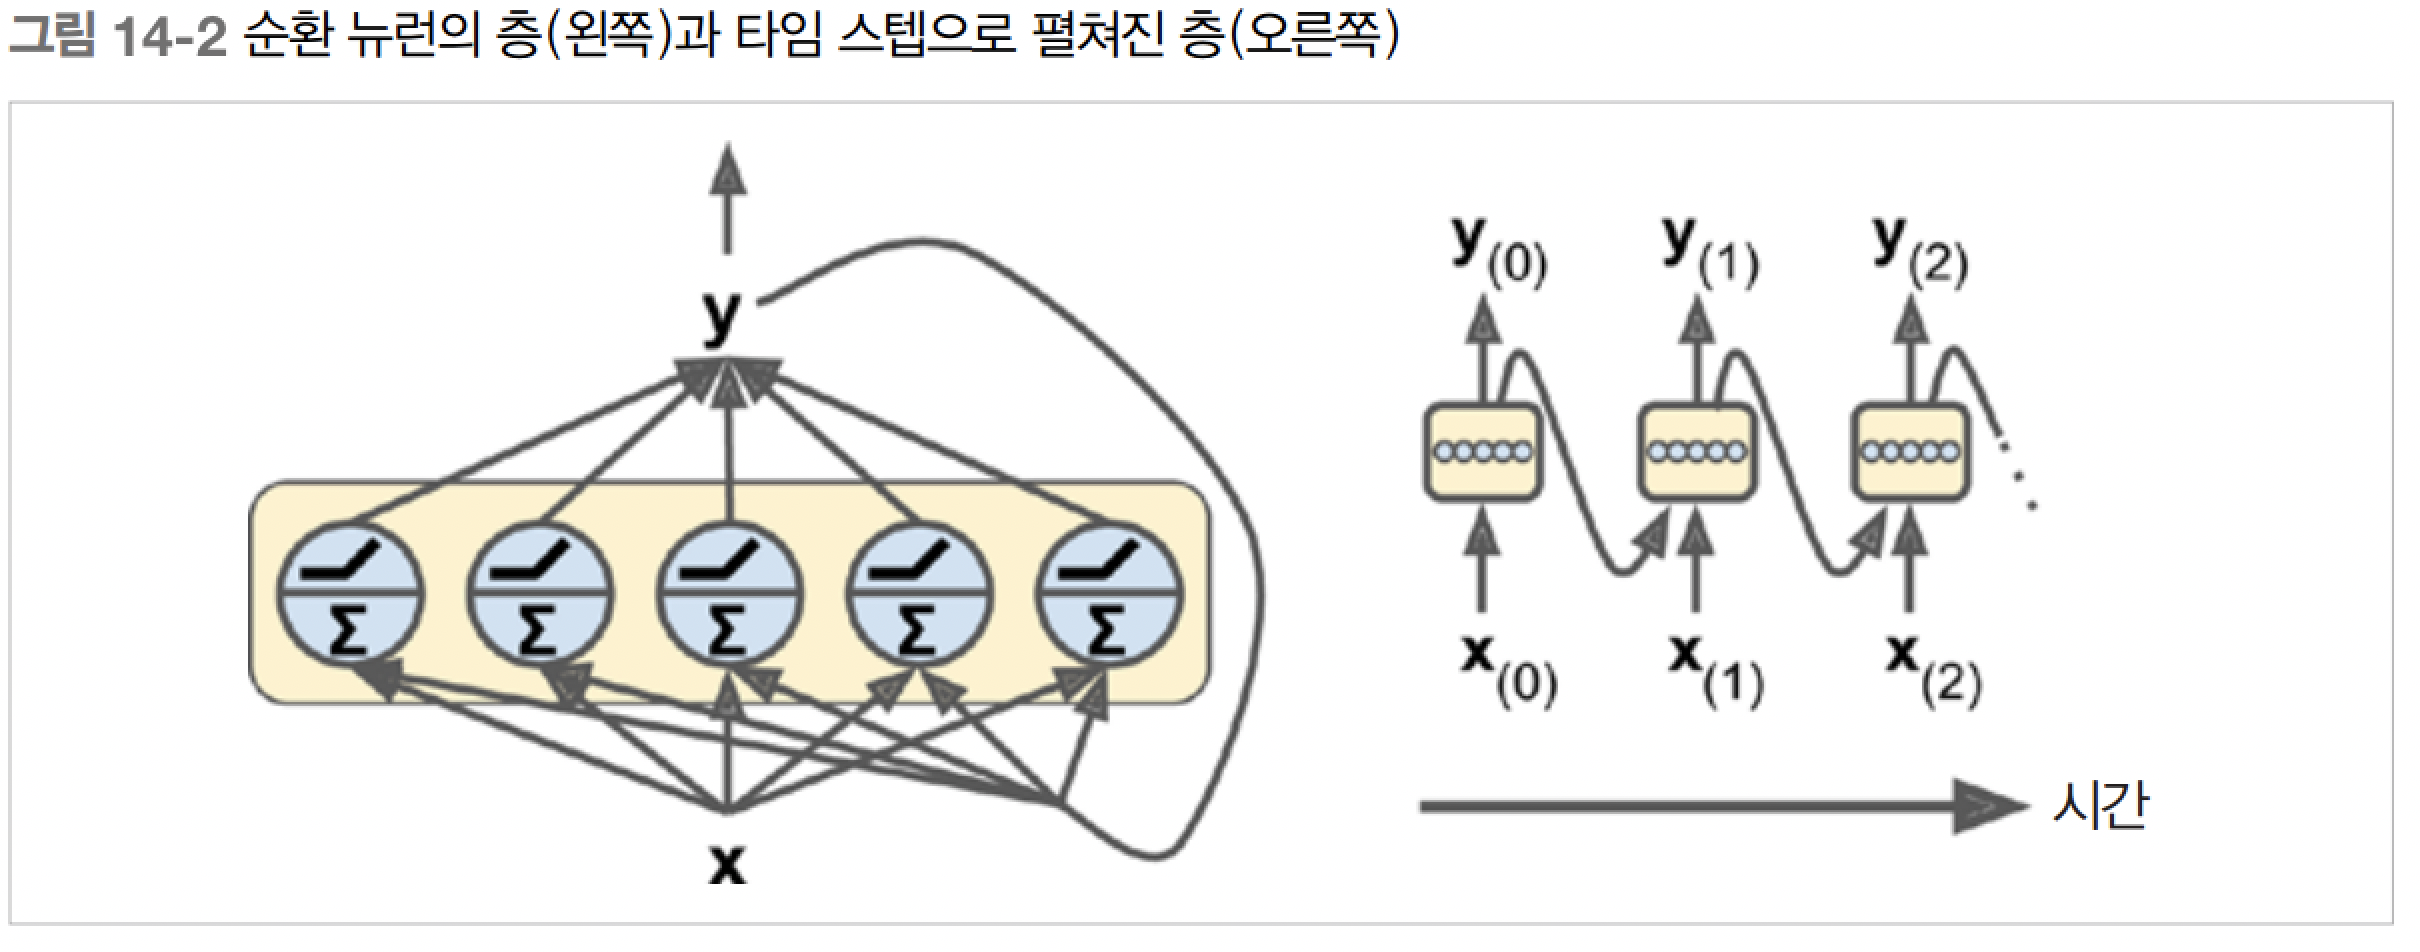

각 순환 뉴런은 두 벌의 가중치를 가집니다. 하나는 입력 x(t) 를 위한 것이고 다른 하나는 이전 타임 스텝의 출력 y(t-1) 을 위한 것입니다. 

가중치 행렬 $\mathbf{W}~x~$ 와 $\mathbf{W}~y~$

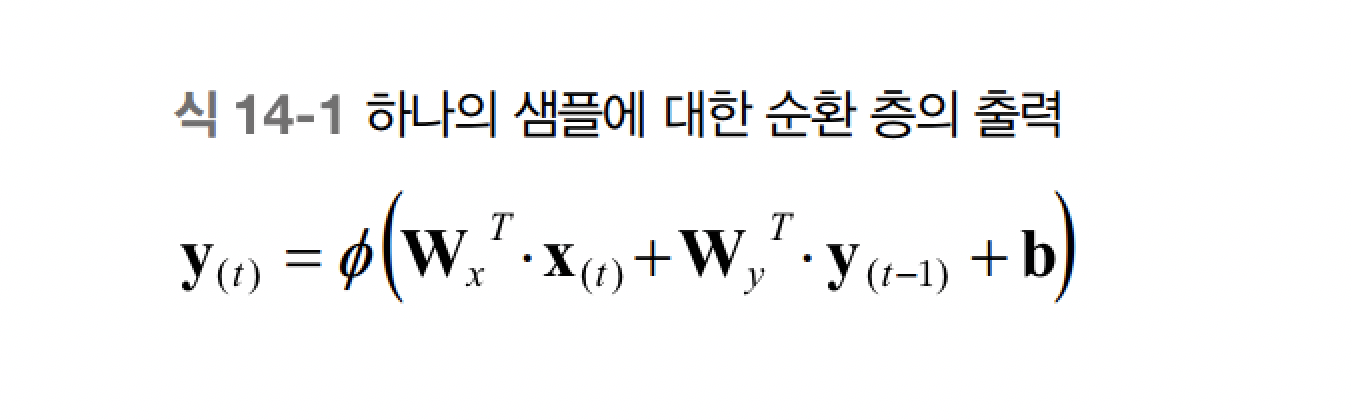

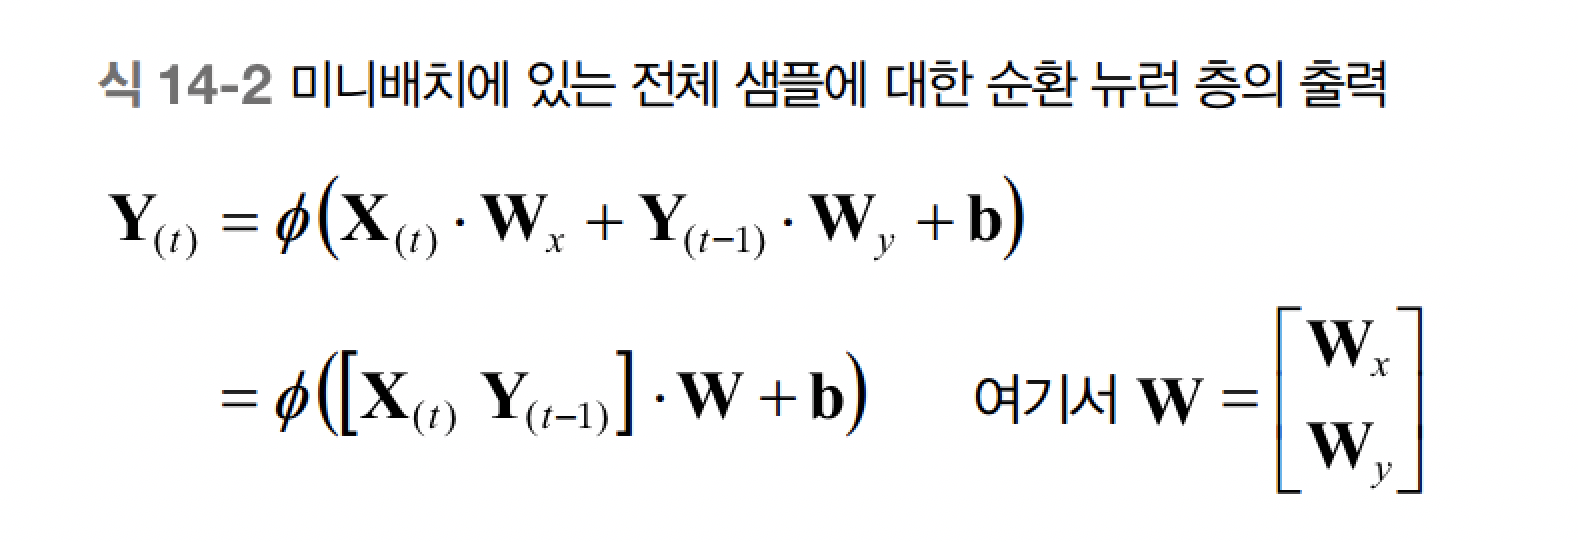

- $\mathbf{Y}~(t)~$ 는 타임 스탭 t에서 미니 배치에 있는 각 샘플에 대한 층의 출력을 담고 있는 $\mathbf{m}$ x $\mathbf{n}~neurons~$ 행렬입니다. ( $\mathbf{m}$은 미니배치에 있는 샘플 수이고 $\mathbf{n}~neurons~$ 는 뉴런 수 입니다 )
- $\mathbf{X}~(t)~$ 는 모든 샘플의 입력 값을 담고 있는 $\mathbf{m}$ x $\mathbf{n}~inputs~$ 행렬입니다. ( $\mathbf{n}~inputs~$ 는 입력 특성 수 입니다 )
- $\mathbf{W}~x~$ 는 현재 타임 스텝의 입력에 대한 연결 가중치를 담고 있는 $\mathbf{n}~inputs~$ x $\mathbf{n}~neurons~$ 행렬입니다.
- $\mathbf{W}~y~$ 는 이전 타임 스텝의 출력에 대한 연결 가중치를 담고 있는 $\mathbf{n}~neurons~$ x $\mathbf{n}~neurons~$ 행렬입니다.
- $\mathbf{b}$  는 각 뉴런의 편향을 담고 있는 $\mathbf{n}~neurons~$ 크기의 벡터입니다.
- 가중치 행렬 $\mathbf{W}~x~$ 와 $\mathbf{W}~y~$ 는 종종 ( $\mathbf{n}~inputs~$ + $\mathbf{n}~neurons~$ ) x $\mathbf{n}~neurons~$ 크기의 가중치 행렬 $\mathbf{W}$ 하나로 연결합니다.
- [ $\mathbf{X}~(t)~$$\mathbf{Y}~(t-1)$ ] 표기는 행렬 $\mathbf{X}~(t)~$$\mathbf{Y}~(t-1)$ 을 수평적으로 연결한다는 것을 나타냅니다.

### 14.1.1 메모리 셀

타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 메모리 셀 (=셀) 이라고 합니다.
하나의 순환 뉴런 또는 순환 뉴런의 층은 매우 기본적인 셀입니다.

타임 스텝 t 에서의 셀의 상태 $\mathbf{h}~(t)~$ 는 그 타임 스텝의 입력과 이전 타임 스텝의 상태에 대한 함수입니다.

$\mathbf{h}~(t)~$ = $\mathbf{f}$( $\mathbf{h}~(t-1)~$, $\mathbf{x}~(t)~$)
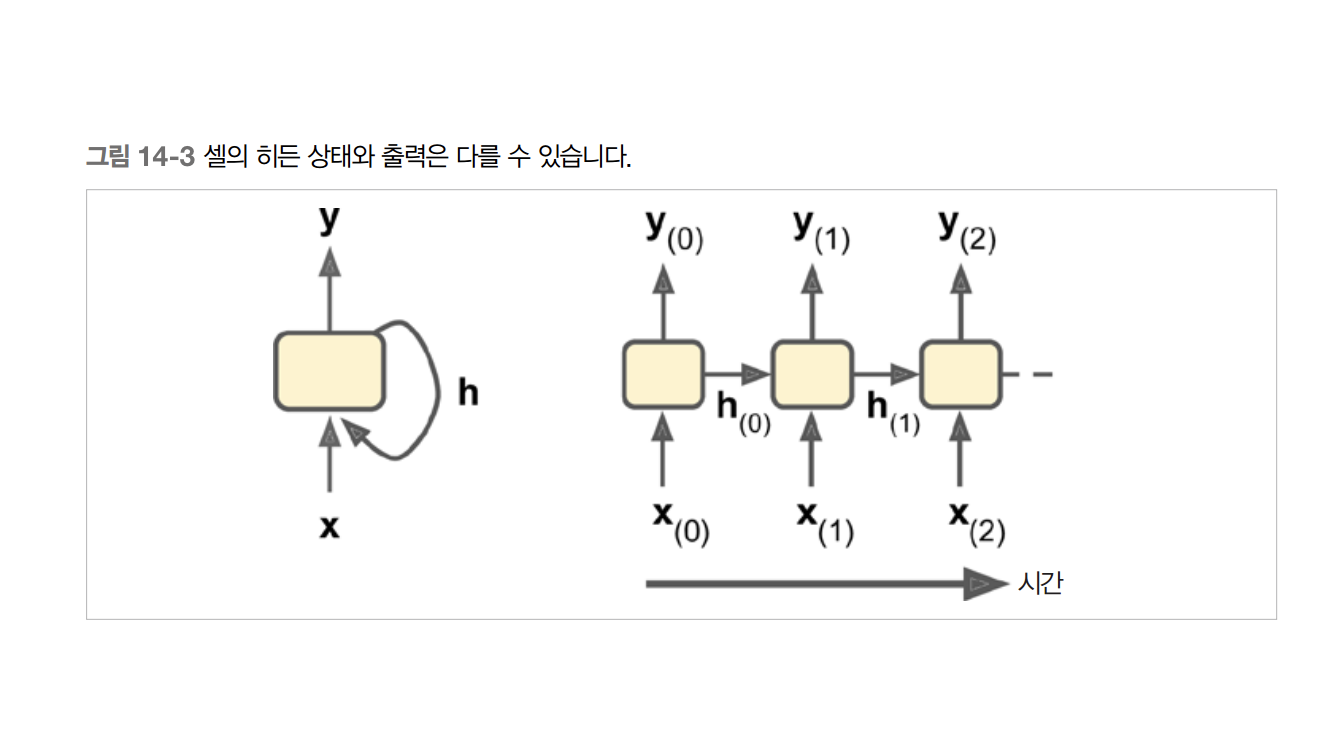


### 14.1.2 입력과 출력 시퀀스
- 시퀀스 투 시퀀스 : 주식 가격 예측
- 시퀀스 투 벡터 : 영화 리뷰 -> 감성 점수
- 벡터 투 시퀀스 : 이미지 캡션
- 지연된 시퀀스 투 시퀀스 : 인코더 디코더 , 번역

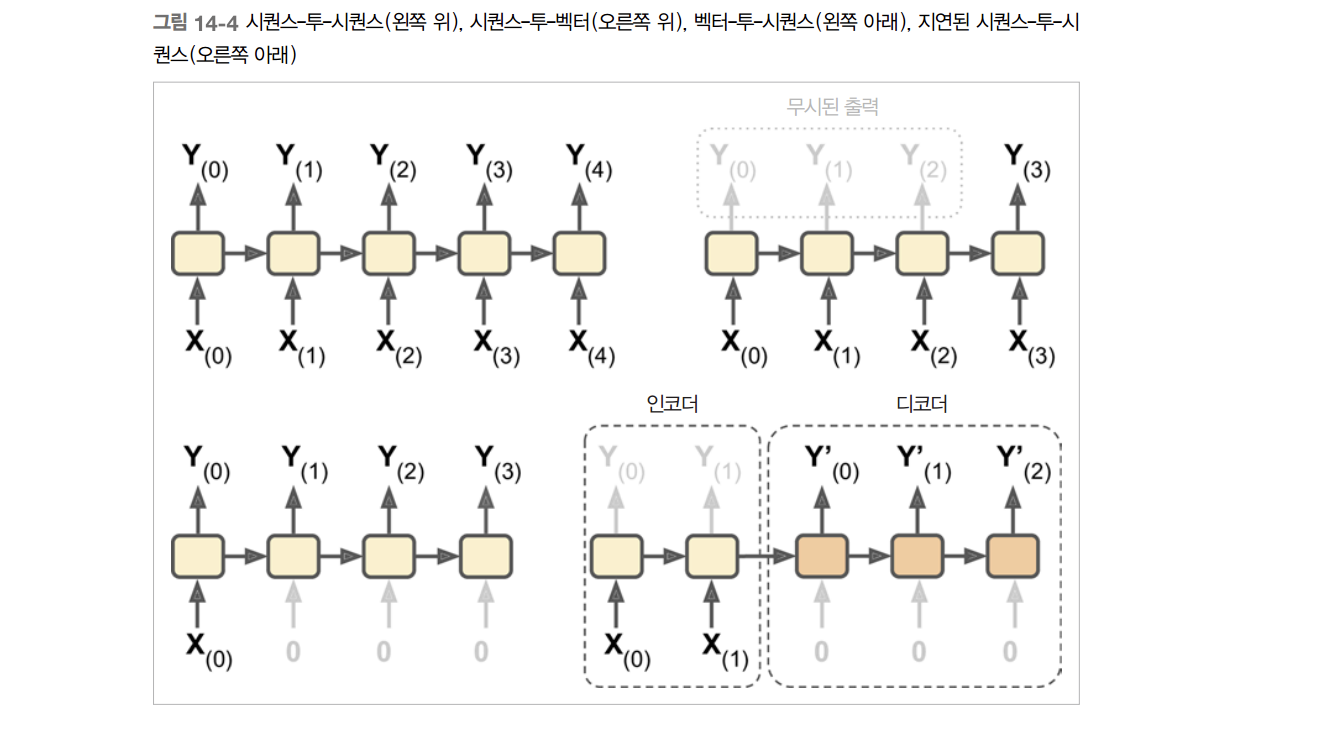



기대가 되네요. 그럼 코딩을 시작해보죠!

### 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

텐서플로를 임포트합니다:

In [2]:
import tensorflow as tf

## 14.2 텐서플로로 기본 RNN 구성하기

#### 텐서플로의 RNN 연산을 전혀 사용하지 않고 간단한 RNN 모델 구현해보겠습니다.

- tanh 활성화 함수
- 다섯 개의 순환 뉴런 층
- 입력 벡터의 크기는 3
- 타임 스텝 2

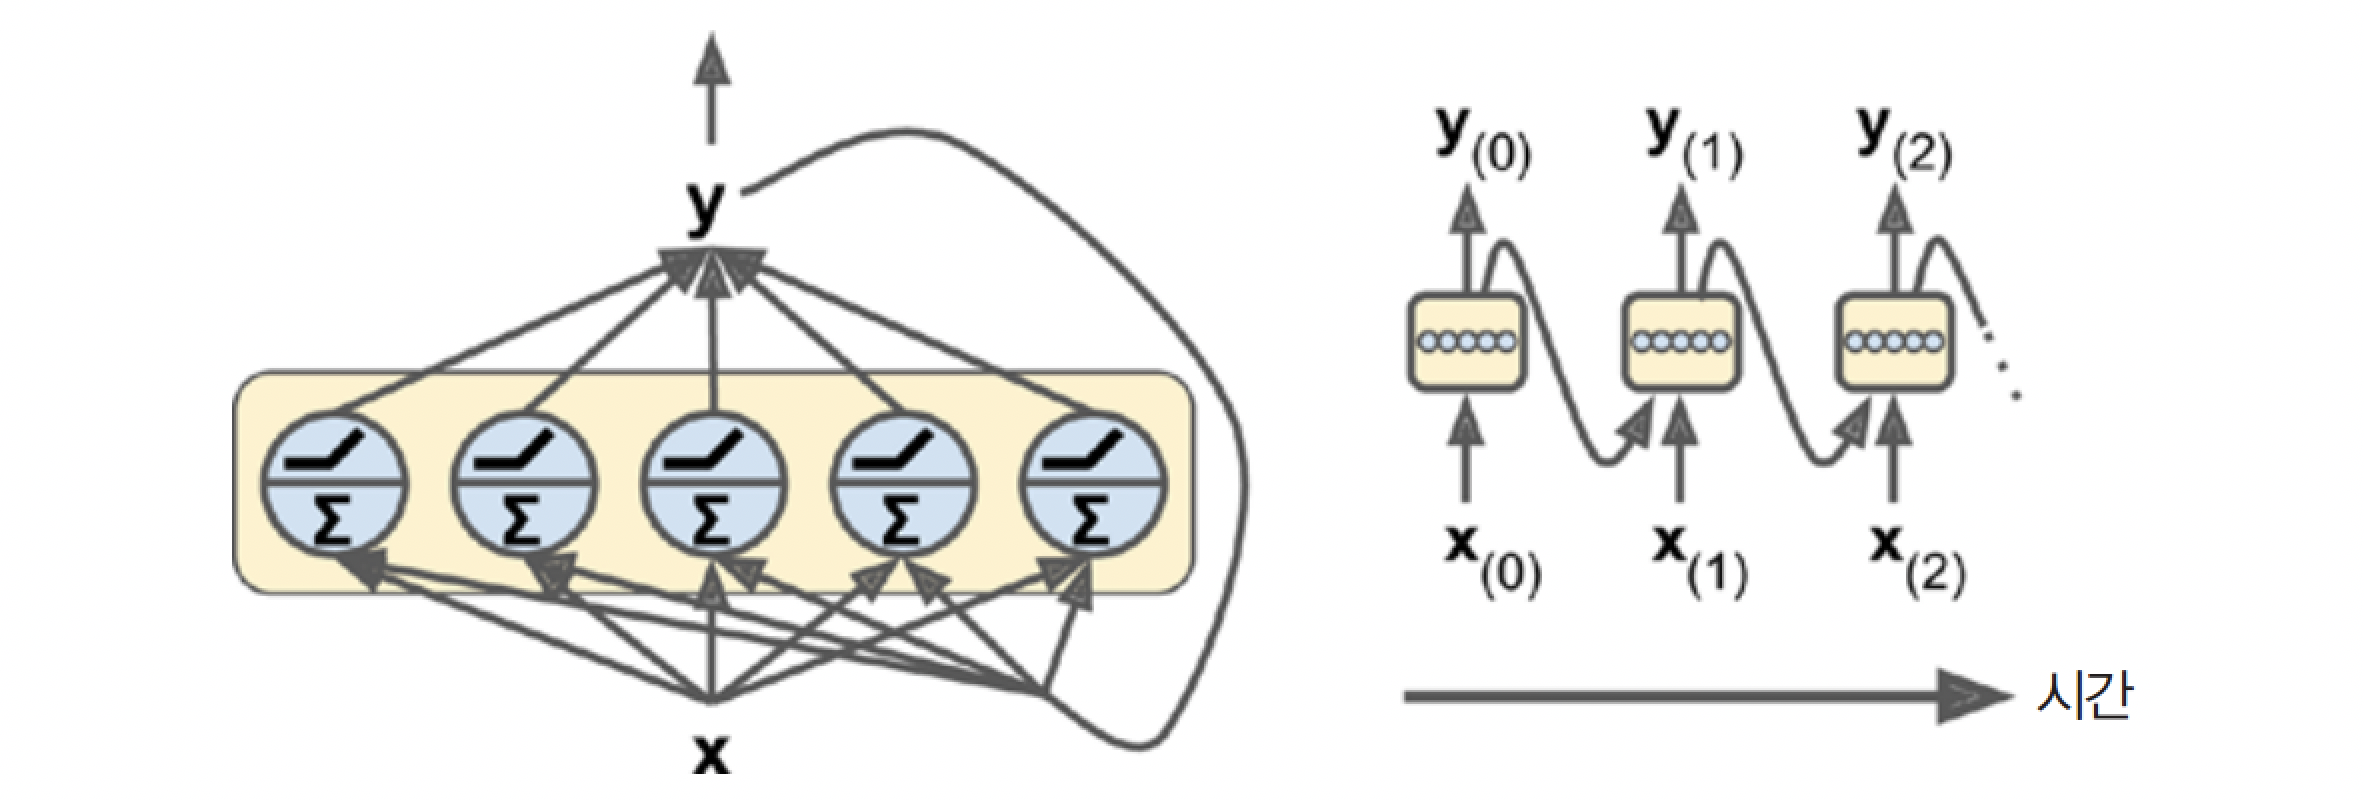

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
import numpy as np

# 미니 배치 :                 샘플 0,   샘플 1,    샘플 2,    샘플 3
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val) # t = 0 에서 출력

[[-0.06640061  0.9625767   0.6810579   0.7091854  -0.89821595]
 [ 0.99777555 -0.7197888  -0.99657613  0.96739244 -0.99989706]
 [ 0.99999785 -0.9989881  -0.99999887  0.9967763  -0.9999999 ]
 [ 1.         -1.         -1.         -0.9981892   0.9995087 ]]


In [6]:
print(Y1_val) # t = 1 에서 출력

[[ 1.         -1.         -1.          0.40200272 -0.99999994]
 [-0.12210429  0.62805295  0.96718436 -0.9937122  -0.2583933 ]
 [ 0.99999815 -0.9999994  -0.99999744 -0.8594331  -0.99998796]
 [ 0.99928296 -0.9999981  -0.9999059   0.98579615 -0.9220575 ]]


### 14.2.1 정적으로 타임 스텝 펼치기

#### `static_rnn()`을 사용하여 만들기

`static_rnn()` 함수는 셀을 연결하여 펼쳐진 RNN 네트워크를 만듭니다.
셀의 복사본을 만드는 팩토리로 생각할 수 있는 `BasicRNNCell` 객체를 `static_rnn()` 함수에 전달 합니다.

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)

Y0, Y1 = output_seqs

`output_seqs` : 각 타임 스탭에서의 출력 텐서를 담고 있는 파이썬 리스트

`states` : 네트워크의 최종 상태를 담고 있는 텐서. 기본적인 셀을 사용할 때는 최종 상태가 마지막 출력과 동일합니다. 

즉, `output_seqs[-1]` 과 `states` 는 동일합니다. 

In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741337, -0.32884312, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.9912275 , -0.95425415, -0.7518078 , -0.9995208 ,  0.98202336],
       [ 0.99992675, -0.99783254, -0.82473516, -0.99999636,  0.99947786],
       [ 0.9967709 , -0.6875061 ,  0.8419969 ,  0.93039113,  0.81206834]],
      dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.9997606 , -0.06679297, -0.9999803 ,  0.99982214],
       [-0.65249425, -0.5152086 , -0.37968948, -0.5922594 , -0.08968376],
       [ 0.998624  , -0.99715203, -0.03308632, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307605 ,  0.7967197 ]],
      dtype=float32)

In [13]:
from tensorflow_graph_in_jupyter import show_graph

In [14]:
show_graph(tf.get_default_graph())

### time step = 50 ?

50개의 타임 스텝이 있다면 50개의 플레이스홀더와 50개의 출력 텐서를 정의하는 건 번거로운 일입니다.
이를 간단히 만들어보죠.

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2])) 
# transpose() 함수로 첫 두차원을 바꿈 [n_steps, None, n_input]
# unstack() 함수로 첫 번째 차원을 따라 텐서의 파이썬 리스트를 추출 ( 즉, 타임 스텝마다 하나의 텐서 ) => n_steps * [None, n_input]
# static_rnn() 에서는 데이터를 처리할 때 타임 스텝 별로 미니배치 데이터를 적용하기 때문에 차원을 변경하여 주입

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])
# stack() 함수를 사용해 모든 출력 텐서를 하나의 텐서로 합침
# transpose() 함수로 첫 두 차원을 바꾸어 [None, n_steps, n_neurons] 크기의 최종 outputs 텐서 만듦

In [17]:
init = tf.global_variables_initializer()

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # 샘플 1
        [[3, 4, 5], [0, 0, 0]], # 샘플 2
        [[6, 7, 8], [6, 5, 4]], # 샘플 3
        [[9, 0, 1], [3, 2, 1]], # 샘플 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

입력 데이터를 준비할 때는 미니배치 크기가 첫 번째 차원이어야 편리하지만, `static_rnn()` 에서 데이터를 처리할 때는 타임 스텝 별로 미니배치 데이터를 적용하기 때문에 차원을 변경하여 주입합니다.

입력된 `X_batch` 데이터가 `transpose()` 되면 아래와 같이 바뀝니다.

In [19]:
print(np.transpose(X_batch, axes=[1, 0, 2]))

[[[0 1 2]
  [3 4 5]
  [6 7 8]
  [9 0 1]]

 [[9 8 7]
  [0 0 0]
  [6 5 4]
  [3 2 1]]]


In [20]:
print(outputs_val)

[[[-0.4565232  -0.6806412   0.40938237  0.631045   -0.45732823]
  [-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]]

 [[-0.80015343 -0.99218273  0.78177965  0.9971032  -0.9964609 ]
  [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]]

 [[-0.93605185 -0.99983793  0.9308867   0.9999814  -0.99998313]
  [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]]

 [[ 0.99273676 -0.9981933  -0.5554365   0.99890316 -0.9953323 ]
  [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]]


In [21]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]
 [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]
 [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]
 [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]


이 방법도 여전히 타임 스텝마다 하나의 셀을 그래프에 추가합니다.
만약 50개 타임 스텝이라면 이 그래프는 매우 복잡해 집니다.

아주 큰 그래프라면 역전파하는 동안 OOM 에러가 발생할 수 있습니다. ( 정방향 패스에 계산된 모든 텐서 저장해서 역방향 패스 그래디언트 계산에 사용하기 때문 )

### 14.2.2 동적으로 타임 스텝 펼치기 

`dynamic_rnn()` 함수는 적절한 타임 스텝에 걸쳐 셀을 싱행하기 위해 `while_loop()` 연산을 사용합니다. 

( => 타임 스텝의 크기에 상관 없이 하나의 행렬곱 연산(`matmul()`) 만 생성됩니다. )

GPU 메모리에서 CPU 메모리로 바꾸어 역전파 시에 OOM 에러를 피할 수 있습니다. ( `swap_memory=True` )

`stack()`, `unstack()`, `transpose()` 가 필요 없습니다.

In [22]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [24]:
init = tf.global_variables_initializer()

In [25]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [26]:
print(outputs_val)

[[[-0.85115266  0.8735834   0.5802911   0.8954789  -0.0557505 ]
  [-0.99999595  0.9999957   0.9981816   1.          0.37679613]]

 [[-0.99832934  0.9992038   0.98071444  0.99998486  0.25192654]
  [-0.7081804  -0.07723369 -0.8522789   0.5845347  -0.7878094 ]]

 [[-0.9999826   0.9999953   0.99928635  1.          0.51590705]
  [-0.9993956   0.9984095   0.83422637  0.9999998  -0.47325197]]

 [[ 0.87888587  0.07356028  0.9721692   0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624865   0.99817705  0.80142   ]]]


In [27]:
show_graph(tf.get_default_graph())

### 14.2.3 가변 길이 입력 시퀀스 다루기

입력 시퀀스가 가변길이면 `sequence_length` 매개변수를 설정합니다.

In [28]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [29]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [30]:
init = tf.global_variables_initializer()

In [31]:
X_batch = np.array([
        # 스텝 0     스텝 1
        [[0, 1, 2], [9, 8, 7]], # 샘플 1
        [[3, 4, 5], [0, 0, 0]], # 샘플 2 (0 벡터로 패딩)
        [[6, 7, 8], [6, 5, 4]], # 샘플 3
        [[9, 0, 1], [3, 2, 1]], # 샘플 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [32]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [33]:
print(outputs_val) # 입력 시퀀스 길이를 초과하는 모든 타임 스텝에 대해 RNN 이 0 벡터를 출력합니다.

[[[-0.91231877  0.16516447  0.5548655  -0.3915935   0.20846416]
  [-1.          0.95672596  0.9983169   0.9997017   0.96518576]]

 [[-0.99986124  0.67022896  0.9723652   0.66310453  0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.89679974  0.9986295   0.96475154  0.93662006]
  [-0.99995255  0.96819544  0.9600286   0.9870626   0.8545923 ]]

 [[-0.9643544   0.9950159  -0.361507    0.99833775  0.99949706]
  [-0.9613586   0.9568762   0.71322876  0.9772921  -0.09582992]]]


In [34]:
print(states_val) # states 텐서는 각 셀의 ( 0 벡터가 제외 된 ) 마지막 상태를 담습니다.

[[-1.          0.95672596  0.9983169   0.9997017   0.96518576]
 [-0.99986124  0.67022896  0.9723652   0.66310453  0.74457586]
 [-0.99995255  0.96819544  0.9600286   0.9870626   0.8545923 ]
 [-0.9613586   0.9568762   0.71322876  0.9772921  -0.09582992]]


### 14.2.4 가변 길이 출력 시퀀스 다루기

출력 시퀀스도 가변 길이라면? 시퀀스 길이를 미리 알 수 있다면 `sequence_length` 매개 변수에 저장할 수 있습니다. 

보통은 미리 알 수 없는데.. 예를 들면 번역 문장 길이는 미리 알 수 없기 때문에 EOS 토큰 (end-of-sequence token)  같은 특별한 출력을 정의해서 이보다 큰 출력은 무시합니다. 

## 14.3 RNN 훈련하기

BPTT ( Backpropagation through time ) : 타임 스텝으로 네트워크를 펼치고 역전파를 사용

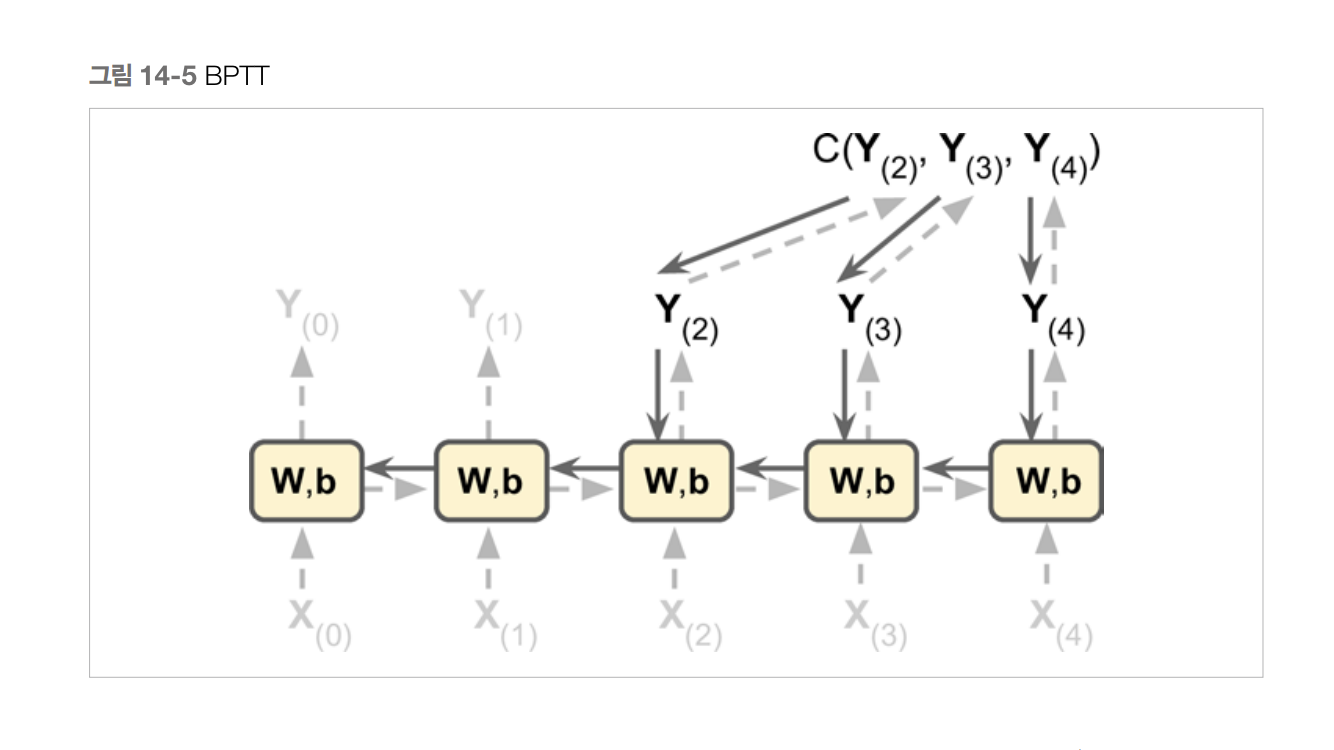

# 14.3.1 시퀀스 분류기 훈련하기

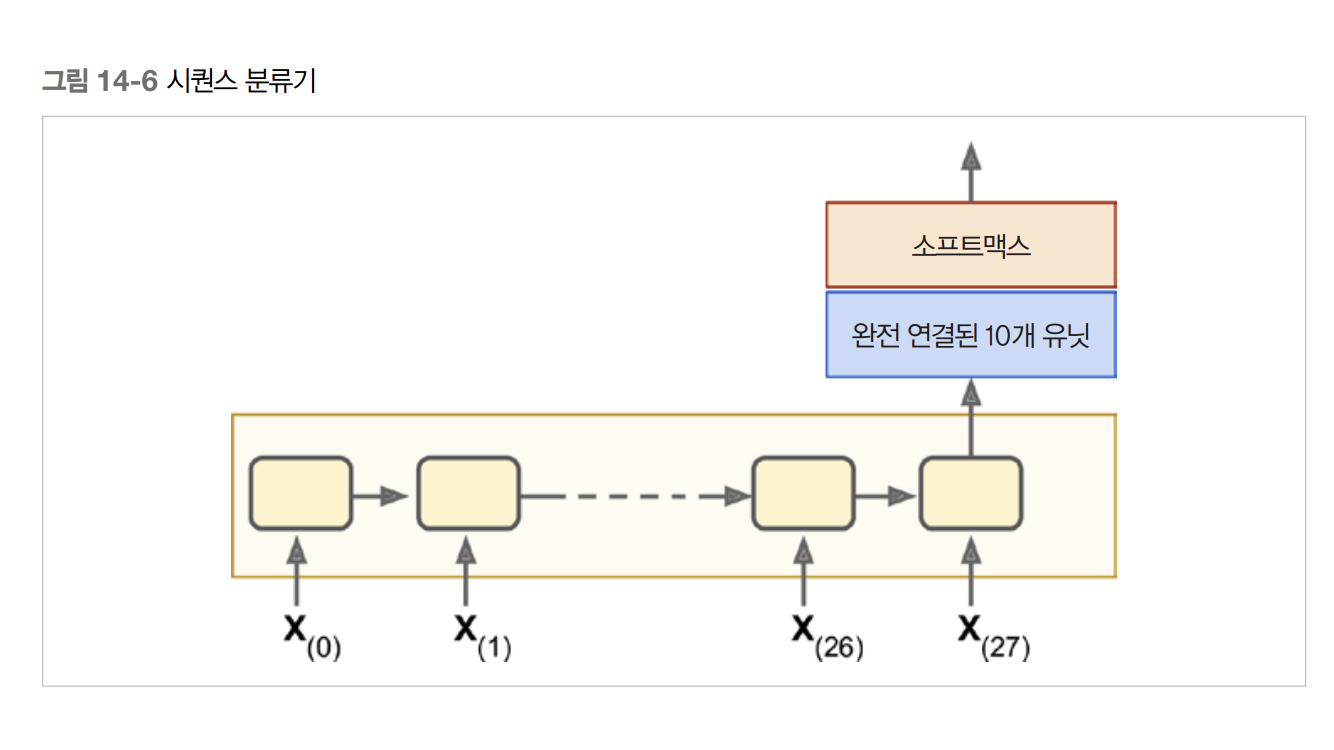

In [35]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs) # fully connected layer
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1) # 타깃 레이블의 예측값이 크기순으로  k번째 안에 들면 True, 그렇지 않으면 False
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [36]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
X_test = X_test.reshape((-1, n_steps, n_inputs))
X_valid = X_valid.reshape((-1, n_steps, n_inputs))

In [37]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [38]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/")
# X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
# y_test = mnist.test.labels

In [39]:
n_epochs = 2 #100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

0 배치 데이터 정확도: 0.9533333 검증 세트 정확도: 0.9322
1 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.953


### 다층 RNN

In [40]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [41]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [42]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [44]:
n_epochs = 2 # 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

0 배치 데이터 정확도: 0.9533333 검증 세트 정확도: 0.9456
1 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9492


### 14.3.2 시계열 예측을 위해 훈련하기

시계열을 다뤄보기 : 입력 시퀀스는 연속된 20개의 값을 랜덤하게 선택, 타깃 시퀀스는 타임 스텝 하나만큼 앞으로 이동

In [ ]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [ ]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("시계열 데이터 (인공 생성)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="훈련 샘플")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("시간")
plt.ylabel("값", rotation=0)

plt.subplot(122)
plt.title("훈련 샘플", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="샘플")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="타깃")
plt.legend(loc="upper left")
plt.xlabel("시간")


save_fig("time_series_plot")
plt.show()

In [ ]:
X_batch, y_batch = next_batch(1, n_steps)

In [ ]:
np.c_[X_batch[0], y_batch[0]]

### `OuputProjectionWrapper` 사용하기

RNN 하나를 만들어 보겠습니다. 이 신경망은 100개의 순환 뉴런을 가지고 있고 각 훈련 샘플은 20개의 입력 길이로 구성되므로 20개의 타임 스텝에 펼칠 것입니다. 각 입력은 하나의 특성을 가집니다(각 시간에서의 값 하나). 타깃도 20개의 입력 시퀀스이고 하나의 값을 가집니다:

In [ ]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

각 타임 스텝에서 크기가 100인 출력 벡터가 만들어 집니다. 하지만 각 타임 스텝에서 하나의 출력 값을 원합니다. 간단한 방법은 `OutputProjectionWrapper`로 셀을 감싸는 것입니다.

각 출력의 상단에 선형 뉴런으로 구성된 완전 연결 층을 ( 즉, 어떤 활성화 함수 없이 ) 추가합니다. ( 셀 상태에는 영향을 주지 않습니다. ) 


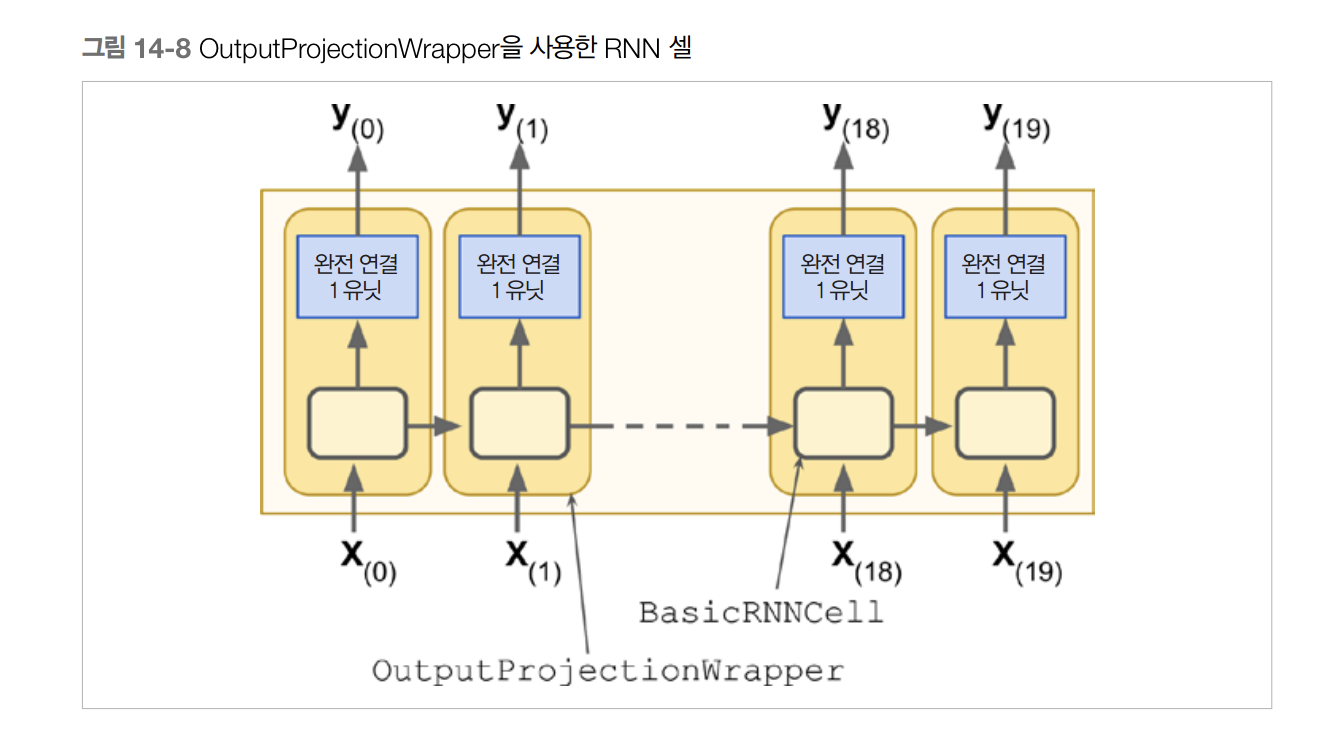

In [ ]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [ ]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [ ]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [ ]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
saver = tf.train.Saver()

In [ ]:
n_iterations = 100 # 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

In [ ]:
with tf.Session() as sess:                          # 책에는 없음
    saver.restore(sess, "./my_time_series_model")   # 책에는 없음

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

In [ ]:
y_pred

In [ ]:
plt.title("모델 테스트", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="샘플")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="타깃")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="예측")
plt.legend(loc="upper left")
plt.xlabel("시간")

save_fig("time_series_pred_plot")
plt.show()

### `OutputProjectionWrapper` 사용하지 않기

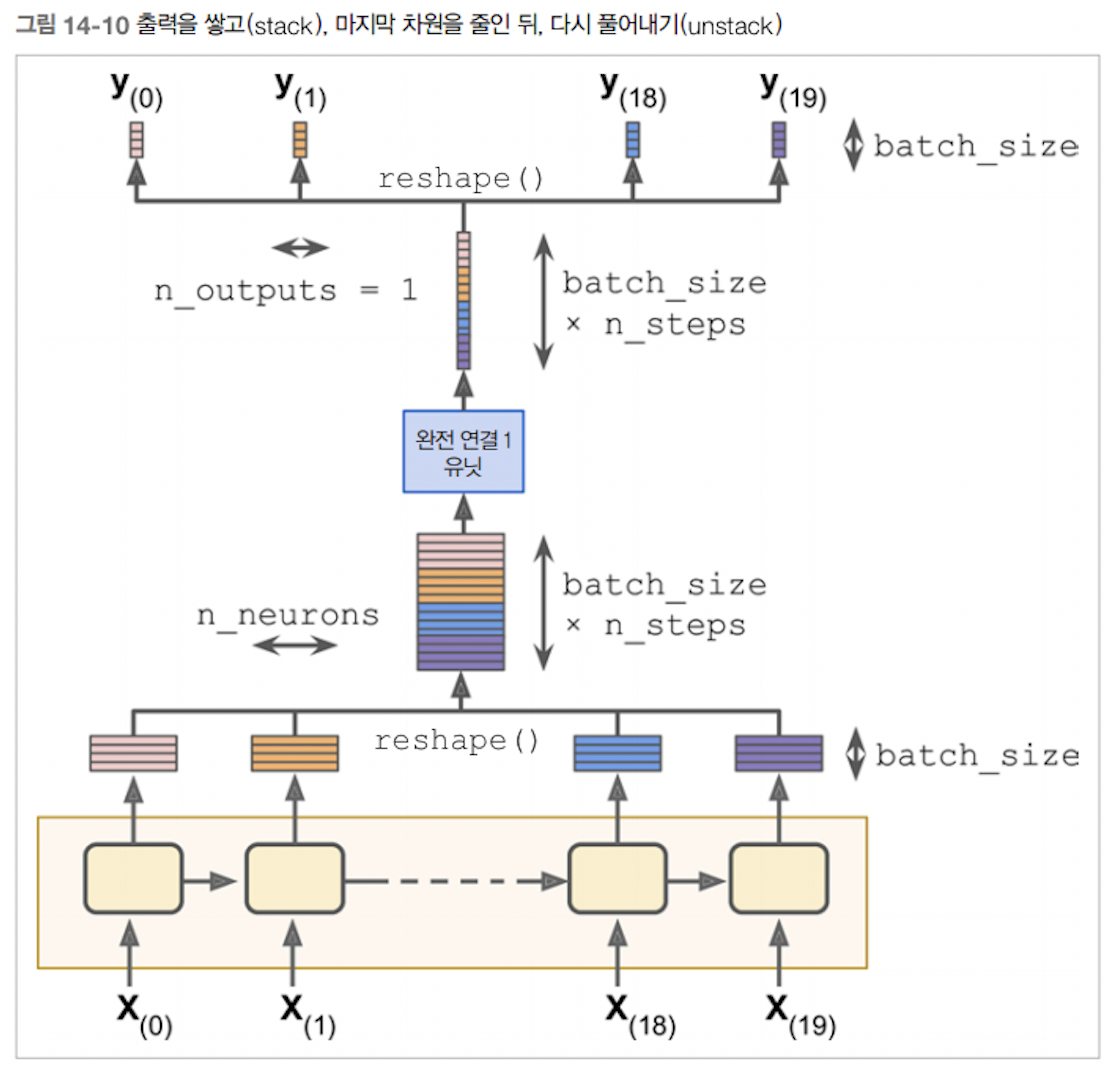

In [ ]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [ ]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [ ]:
n_outputs = 1
learning_rate = 0.001

In [ ]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [ ]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_iterations = 100 # 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

In [ ]:
y_pred

In [ ]:
plt.title("모델 테스트", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("시간")

plt.show()

### 14.3.3 RNN의 창조성

미래를 예측할 수 있는 모델을 만들었습니다. 이 모델을 사용해 새로운 시퀀스를 창조할 수 있습니다.


In [ ]:
with tf.Session() as sess:                        # 책에는 없음
    saver.restore(sess, "./my_time_series_model") # 책에는 없음

    sequence = [0.] * n_steps # n_steps 값을 가지는 시드 시퀀스
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0]) # 예측한 값을 시퀀스 끝에 추가하고 마지막 n_steps 값을 모델에 주입해서 다시 예측

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("시간")
plt.ylabel("값")
plt.show()

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("시간")
plt.ylabel("값", rotation=0)

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("시간")
save_fig("creative_sequence_plot")
plt.show()

## 14.4 심층 RNN

셀을 여러 층으로 쌓는 것은 상당히 일반적이며, 이를 심층 RNN ( Deep RNN ) 이라고 합니다. 

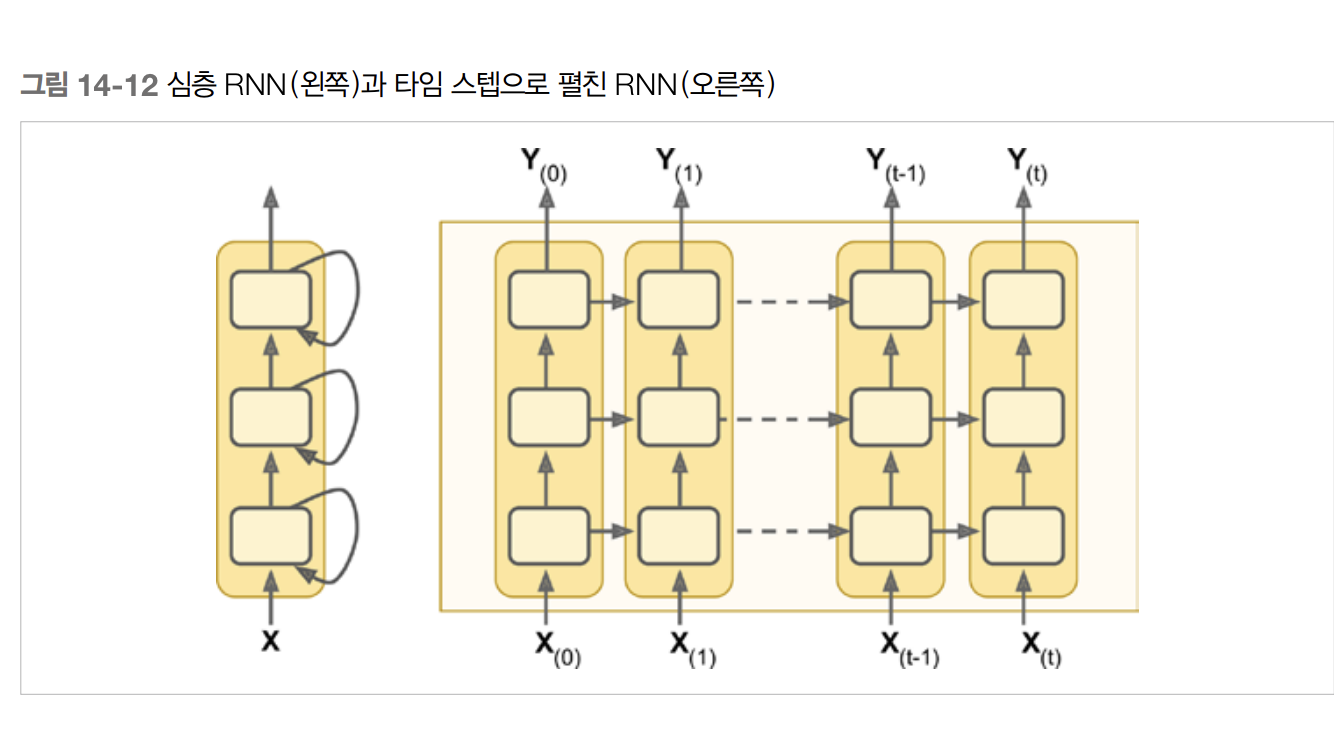

#### MultiRNNCell

심층 RNN을 텐서플로로 구현하려면 여러 개의 셀을 만들어 MultiRNNCell 로 쌓아 올립니다. 

In [ ]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [ ]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [ ]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [ ]:
outputs_val.shape

### 14.4.1 여러 GPU에 심층 RNN 분산하기

이렇게 사용해서는 **안됩니다**:

In [ ]:
with tf.device("/gpu:0"):  # 이 할당은 무시됩니다
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # 이 할당은 무시됩니다
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

대신 `DeviceCellWrapper`를 사용합니다:

In [ ]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [ ]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [ ]:
devices = ["/gpu:0", "/gpu:1", "/gpu:2"] # 만약 GPU가 네 개 있다면 ["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"]로 바꿉니다
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

또 다른 방법으로 텐서플로 1.1부터 `tf.contrib.rnn.DeviceWrapper` 클래스를 사용할 수 있습니다(텐서플로 1.2부터는 `tf.nn.rnn_cell.DeviceWrapper`가 되었습니다).

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

### 14.4.2 드롭아웃 적용하기

깊은 RNN 을 만들면 훈련 세트에 과대적합 되기 쉽습니다. 이를 막기 위해 드롭아웃을 적용합니다.
RNN 의 전후에 드롭아웃 층을 추가할 수 있습니다. `DropoutWrapper` 클래스를 사용합니다. 

In [ ]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [ ]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

노트: `input_keep_prob` 매개변수는 플레이스홀더로 훈련하는 동안에는 어느 값이나 가능하고 테스트할 때는 1.0으로 지정합니다(드롭아웃을 끕니다).

In [ ]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [ ]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_iterations = 100 # 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "훈련 MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

In [ ]:
plt.title("모델 테스트", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("시간")

plt.show()

이런 드롭아웃이 이 경우엔 크게 도움이 안되네요. :/

### 14.4.3 많은 타임 스텝에서 훈련의 어려움

많은 타임 스텝에서 실행해야 하므로 편친 RNN이 매우 깊은 네트워크가 됩니다. 
이를 해결하기위해 제한된 타임 스텝에 역전파 하면 됩니다. ( 일정한 타임 스텝 만큼만 RNN을 펼치는 것입니다. 
)

`n_steps` 를 줄이면 되는데.. 장기간 패턴을 학습할 수 없는 문제가 있습니다.
또한, 긴 시간 RNN을 실행함으로써 첫 번째 입력의 기억이 점차 사라지는 문제가 있습니다.

## 14.5 LSTM 셀

LSTM ( Long shrot-term memory ) 셀은 훈련이 빠르게 수렴하고 장기간의 의존성을 감지합니다.
`BasicRNNCell` 대신 `BasicLSTMCell` 을 사용하면 됩니다.


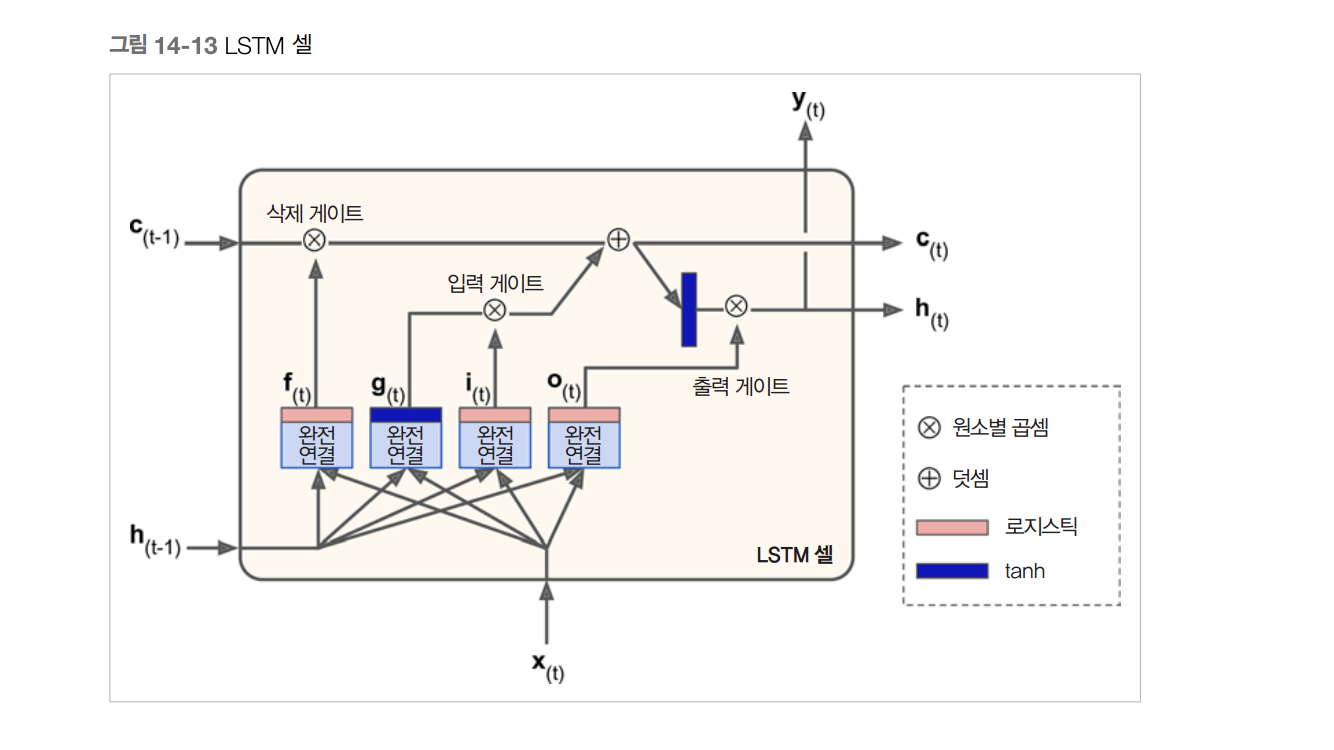


셀 외부에서 보면
LSTM 셀은 상태가 두개의 벡터 $\mathbf{h}~(t)~$ 와 $\mathbf{c}~(t)~$ 로 나뉩니다.
$\mathbf{h}~(t)~$ 를 단기 상태 ( short-term state ), $\mathbf{c}~(t)~$ 를 장기 상태 ( long-term state ) 라고 생각 할 수 있습니다.

`BasicRNNCell` 대신 `BasicLSTMCell` 을 사용하면 됩니다.

In [ ]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [ ]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [ ]:
states

In [ ]:
top_layer_h_state

In [ ]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("에포크", epoch, "배치 데이터 정확도 =", acc_batch, "검증 세트 정확도 =", acc_valid)
    
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("테스트 세트 정확도 =", acc_test)

### 14.5.1 핍홀 연결 

기본적 LSTM 셀 보다 장기 상태도 조금 노출시켜 더 많은 문맥을 감지하게 만든 연결
`BasicLSTMCell` 대신 `LSTMCell` 을 사용하고 `use_peepholes=True` 로 지정

In [ ]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

## 14.6 GRU 셀

게이트 순환 유닛 ( Gate Recurrent Unit = GRU ) 셀은 LSTM 의 간소화 버전이고 유사하게 작동합니다.

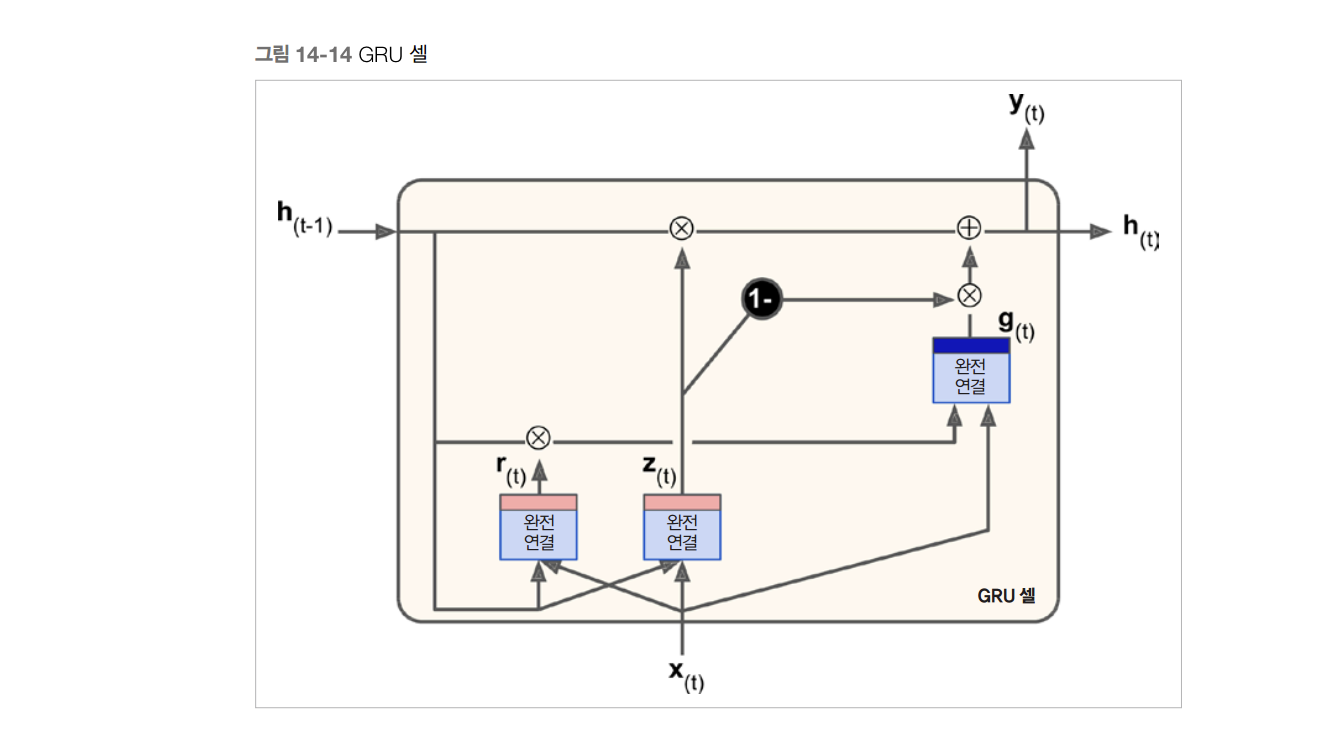

In [ ]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

## 14.7 자연어 처리

기계 번역, 자동 요약, 파싱, 감성 분석 등 NLP 어플리케이션 대부분은 RNN 기반으로 하고 있습니다. 


### 14.7.1 워드 임베딩
단어 표현 방법
1. 원-핫 벡터
2. 임베딩

이 섹션은 텐서플로의 [Word2Vec 튜토리얼](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html)을 기반으로 합니다.

### 데이터 추출

In [45]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """디렉토리 생성, 이미 있다면 그냥 통과
    
    이 함수는 파이썬 2 버전을 지원하기 위해서입니다.
    파이썬 3.2 이상이면 다음과 같이 쓸 수 있습니다:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [46]:
words = fetch_words_data()

URLError: <urlopen error [Errno 110] Connection timed out>

In [ ]:
words[:5]

### 사전 구축

In [ ]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [ ]:
" ".join(words[:9]), data[:9]

In [ ]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

In [ ]:
words[24], data[24]

### 배치 생성

In [ ]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # buffer 중간에 타깃 레이블을 둡니다
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [ ]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [ ]:
batch, [vocabulary[word] for word in batch]

In [ ]:
labels, [vocabulary[word] for word in labels[:, 0]]

### 모델 구성

In [ ]:
batch_size = 128
embedding_size = 128  # 임베딩 벡터 차원
skip_window = 1       # 고려할 왼쪽과 오른쪽 단어의 개수
num_skips = 2         # 레이블을 생성하기 위한 입력의 재사용 횟수

# 가까운 이웃을 샘플링하기 위해 랜덤한 검증 세트를 만듭니다.
# 검증 샘플은 가장 흔한 단어인 낮은 ID 번호를 가진 것으로 제한합니다.
valid_size = 16     # 유사도를 평가하기 위해 랜덤하게 구성할 단어 세트 크기
valid_window = 100  # 검증 샘플을 전체 샘플의 앞 부분에서만 선택합니다
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # 부정 샘플링(negative sampling)의 수

learning_rate = 0.01

In [ ]:
reset_graph()

# 입력 데이터
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [ ]:
vocabulary_size = 50000
embedding_size = 150

# 입력을 위해 임베딩을 조회합니다
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [ ]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [ ]:
# NCE 손실을 위한 변수를 만듭니다
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# 배치에서 NCE 손실의 평균을 계산합니다.Compute the average NCE loss for the batch.
# tf.nce_loss는 자동으로 손실을 평가할 때마다 음성 레이블에서 새로운 샘플을 뽑습니다.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Adam 옵티마이저
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# 미니배치 샘플과 모든 임베딩 사이의 코사인 유사도를 계산합니다
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# 초기화를 위한 연산
init = tf.global_variables_initializer()

### 모델 훈련

In [ ]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\r반복: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # 훈련 연산을 평가하여 스텝을 한 단계를 업데이트합니다(session.run()에서 반환된 값을 사용합니다)
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # 평균 손실은 2000개 배치에 대한 손실의 추정입니다.
            print("스텝 ", step, "에서의 평균 손실: ", average_loss)
            average_loss = 0

        # 이 코드는 비용이 많이 듭니다 (500 스텝마다 ~20%씩 느려집니다)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # 가장 가까운 단어의 개수
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "%s에 가장 가까운 단어:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

마지막 임베딩을 저장합니다(물론 텐서플로의 `Saver`를 사용해도 됩니다):

In [ ]:
np.save("./my_final_embeddings.npy", final_embeddings)

#### 임베딩 그래프

In [ ]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "임베딩보다 레이블이 많습니다."
    plt.figure(figsize=(18, 18))  # 인치 크기
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

### 14.7.2 기계 번역을 위한 인코더-디코더 네트워크

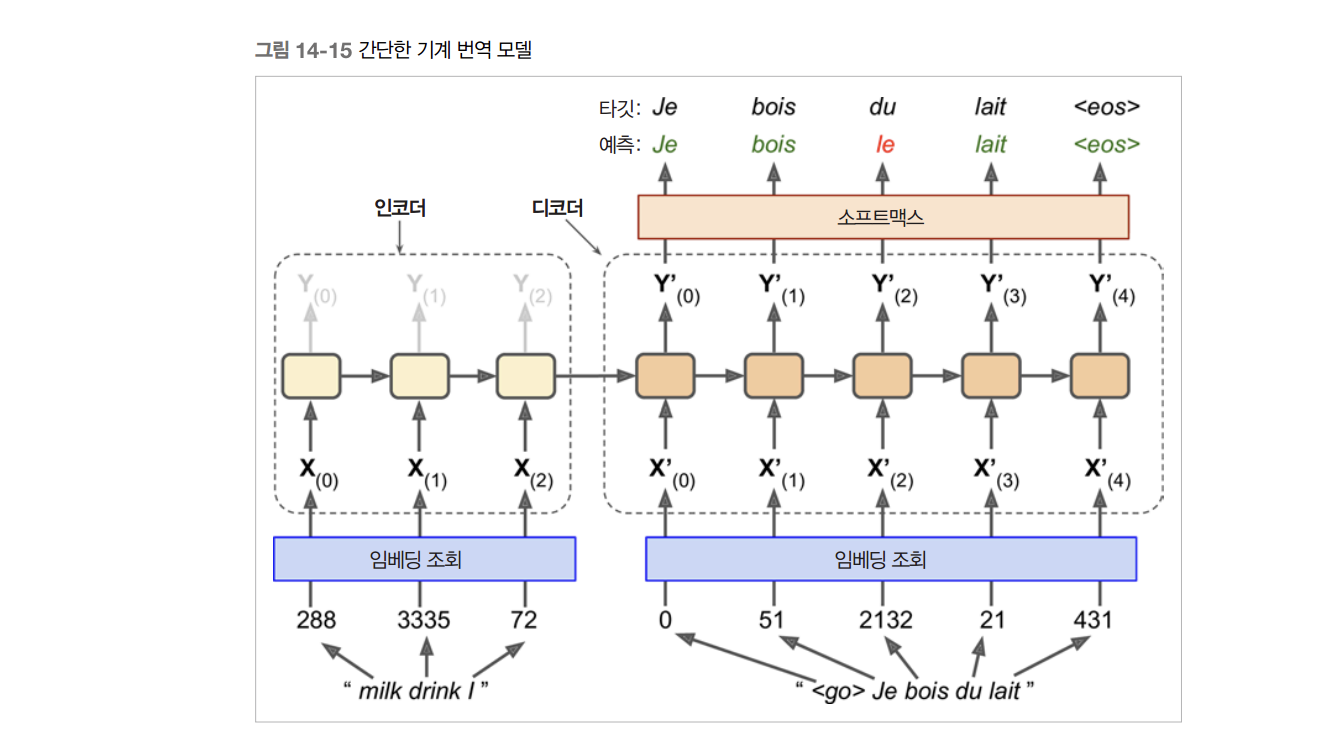

`basic_rnn_seq2seq()` 함수는 간단한 인코더/디코더 모델을 만듭니다. 먼저 `encoder_inputs`를 상태 벡터로 인코딩하는 RNN을 실행하고 그다음 `decoder_inputs`을 마지막 인코더 상태로 초기화시킨 디코더를 실행합니다. 인코더와 디코더는 같은 RNN 셀 타입을 사용하지만 파라미터를 공유하지는 않습니다.

In [ ]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # 영어 문장
Y = tf.placeholder(tf.int32, [None, n_steps]) # 프랑스어 번역
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # 1D 텐서의 리스트
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # 1D 텐서의 리스트

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [ ]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# 연습문제 해답

## 1. to 6.

부록 A 참조.

## 7. 임베딩된 레버(Reber) 문법

먼저 문법에 맞는 문자열을 생성하는 함수가 필요합니다. 이 문법은 각 상태에서 가능한 전이 상태의 리스트입니다. 하나의 전이는 출력할 문자열(또는 생성할 문법)과 다음 상태를 지정합니다.

In [ ]:
from random import choice, seed

# 일관된 출력을 위한 유사난수 초기화
seed(42)
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (상태 0) =B=>(상태 1)
    [("T", 2), ("P", 3)], # (상태 1) =T=>(상태 2) or =P=>(상태 3)
    [("S", 2), ("X", 4)], # (상태 2) =S=>(상태 2) or =X=>(상태 4)
    [("T", 3), ("V", 5)], # 등등..
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (상태 6) =E=>(종료 상태)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        production, state = choice(grammar[state])
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

기본 레버 문법에 맞는 문자열을 몇 개 만들어 보겠습니다:

In [ ]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

좋습니다. 이제 임베딩된 레버 문법에 맞는 문자열을 몇 개 만들어 보겠습니다:

In [ ]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

좋네요, 이제 이 문법을 따르지 않는 문자열을 생성할 함수를 만듭니다. 무작위하게 문자열을 만들 수 있지만 그렇게 하면 너무 문제가 쉬워지므로 대신 문법을 따르는 문자열을 만든 후 하나의 문자만 바꾸어 놓도록 하겠습니다:

In [ ]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = choice(list(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

잘못된 문자열 몇 개를 만들어 보죠:

In [ ]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

문자열을 바로 RNN에 주입할 수는 없습니다. 먼저 벡터의 연속으로 바꾸어야 합니다. 각 벡터는 원-핫 인코딩을 사용하여 하나의 문자를 나타냅니다. 예를 들어, 벡터 `[1, 0, 0, 0, 0, 0, 0]`는 문자 "B"를 나타내고 벡터 `[0, 1, 0, 0, 0, 0, 0]`는 문자 "E"를 나타내는 식입니다. 이런 원-핫 벡터의 연속으로 문자열을 바꾸는 함수를 작성해 보겠습니다. 문자열이 `n_steps`보다 짧으면 0 벡터로 패딩됩니다(나중에, 텐서플로에게 각 문자열의 실제 길이를 `sequence_length` 매개변수로 전달할 것입니다).

In [ ]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for index, char in enumerate(string):
        output[index, char_to_index[char]] = 1.
    return output

In [ ]:
string_to_one_hot_vectors("BTBTXSETE", 12)

이제 50%는 올바른 문자열 50%는 잘못된 문자열로 이루어진 데이터셋을 만듭니다:

In [ ]:
def generate_dataset(size):
    good_strings = [generate_string(embedded_reber_grammar)
                    for _ in range(size // 2)]
    bad_strings = [generate_corrupted_string(embedded_reber_grammar)
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    n_steps = max([len(string) for string in all_strings])
    X = np.array([string_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good_strings))] +
                 [[0] for _ in range(len(bad_strings))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [ ]:
X_train, l_train, y_train = generate_dataset(10000)

첫 번째 훈련 샘플을 확인해 보겠습니다:

In [ ]:
X_train[0]

데이터셋에서 가장 긴 문자열 때문에 패딩된 0 벡터가 많습니다. 문자열 길이가 얼마나 될까요?

In [ ]:
l_train[0]

타깃 클래스는?

In [ ]:
y_train[0]

아주 좋습니다! 올바른 문자열을 구분할 RNN을 만들 준비가 되었습니다. 앞서 MNIST 이미지를 분류하기 위해 만든 것과 매우 비슷한 시퀀스 분류기를 만듭니다. 차이점은 다음 두 가지입니다:
* 첫째, 입력 문자열이 가변 길이이므로 `dynamic_rnn()` 함수를 호출할 때 `sequence_length`를 지정해야 합니다.
* 둘째, 이진 분류기이므로 출력 뉴런은 하나만 필요합니다. 이 뉴런은 각 문자열에 대해 올바른 문자열일 추정 로그 확률을 출력할 것입니다. 다중 클래스 분류에서는 `sparse_softmax_cross_entropy_with_logits()`를 사용했지만 이진 분류에서는 `sigmoid_cross_entropy_with_logits()`를 사용합니다.

In [ ]:
reset_graph()

possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1

learning_rate = 0.02
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
seq_length = tf.placeholder(tf.int32, [None], name="seq_length")
y = tf.placeholder(tf.float32, [None, 1], name="y")

gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

logits = tf.layers.dense(states, n_outputs, name="logits")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")
y_proba = tf.nn.sigmoid(logits, name="y_proba")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

훈련하는 동안 진척 상황을 확인할 수 있도록 검증 세트를 만듭니다:

In [ ]:
X_val, l_val, y_val = generate_dataset(5000)

In [ ]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}  훈련 손실: {:.4f}, 정확도: {:.2f}%  검증 세트 정확도: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "./my_reber_classifier")

이제 두 개의 문자열에 이 RNN을 테스트해 보죠. 첫 번째는 잘못된 것이고 두 번째는 올바른 것입니다. 이 문자열은 마지막에서 두 번째 글자만 다릅니다. RNN이 이를 맞춘다면 두 번째 문자가 항상 끝에서 두 번째 문자와 같아야 한다는 패턴을 알게 됐다는 것을 의미합니다. 이렇게 하려면 꽤 긴 단기 기억(long short-term memory)이 필요합니다(그래서 GRU 셀을 사용했습니다).

In [ ]:
test_strings = [
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVETE",
    "BPBTSSSSSSSSSSSSXXTTTTTVPXTTVPXTTTTTTTVPXVPXVPXTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "my_reber_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("레버 문자열일 추정 확률:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, y_proba_val[index][0]))

쨘! 잘 작동하네요. 이 RNN이 완벽한 신뢰도로 정확한 답을 냈습니다. :)

## 8. 과 9.

Coming soon...